In [1]:
import xml.etree.cElementTree as ET
from IPython.display import clear_output
from ipywidgets import FloatProgress, IntText
from IPython.display import display
from nltk.tokenize.stanford import StanfordTokenizer
from nltk.tokenize import word_tokenize
import nltk
import time
import re
import pandas as pd
import collections
from math import log 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#nltk.download()

# Extracting Articles from Specific Categories

This is my first attempt at processing the Wikipedia dump.  It streamingly parses the Wikipedia XML and processes any article with a category tag that contains the specified strings.  Currently, it just writes the body of the articles to both a single file and a category specific file.  It probably should also do the tokenization, but doesn't yet.

In [7]:
class ArticleProcessor:
    
    def __init__(self, categories):
        self.categories = categories        
        self.global_matcher = re.compile("\[\[Category:[^\]]*(" + 
                                         "|".join(categories) + 
                                         ")[^\]]*", re.IGNORECASE)
        self.category_matcher = {}
        self.article_writer = {}
        self.global_writer = open("data/all-articles", "w")
        for category in self.categories:
            self.category_matcher[category] = re.compile("\[\[Category:[^\]]*" + 
                                                         category + 
                                                         "[^\]]*", re.IGNORECASE)
            self.article_writer[category] = open("data/" + category + "-articles", "w")
            
    def is_article_of_interest(self, article_text):
        return self.global_matcher.search(article_text)

    def process_article(self, article_text):
        self.global_writer.write(article_text)
        self.global_writer.write("\n")
        for category in self.categories:
            if self.category_matcher[category].search(article_text):
                self.article_writer[category].write(article_text)
                self.article_writer[category].write("\n")
    
    def close_all(self):
        self.global_writer.close()
        for writer in self.article_writer.values():
            writer.close()
    

In [10]:
#Don't run this

p = ET.iterparse("data/enwiki-20170820-pages-articles.xml", 
                 events=("start", "end"))

start = time.time()
article_count = 0
root = None
f = FloatProgress(min=0, max=17773690)
t = IntText(value=0, description="Articles")
m = IntText(value=0, description="Matching Articles")
display(t, m, f)

processor = ArticleProcessor(["sportspeople",
                              "artists",
                              "politicians",
                              "military personnel",
                              "scientist",
                              #sportmanager
                              #cleric
                              "monarch",
                              "Fictional\ characters",
                              "nobility",
                              "criminals",
                              "judges"
                              
                             ])
try:
    
    for event, elem in p:
        if root == None:
            root = elem
        if event == "end" and elem.tag == '{http://www.mediawiki.org/xml/export-0.10/}text':
            article_count += 1
            if article_count % 1000 == 0:
                f.value = article_count
                t.value = article_count
            if elem.text and processor.is_article_of_interest(elem.text):
                m.value += 1 
                processor.process_article(elem.text)
            root.clear()
finally:
    processor.close_all()
    print("Articles:", article_count, "Time:", (time.time() - start), "seconds")

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Articles: 17773690 Time: 5338.332955360413 seconds


# Extracting Articles with Gender Labels

In [2]:
gender_label_table = pd.read_csv("data/wiki.genders.txt", sep='\t')
gender_label_table.head(10)

,wiki id,gender,name
0,307,MALE,Abraham Lincoln
1,339,FEMALE,Ayn Rand
2,340,MALE,Alain Connes
3,344,MALE,Allan Dwan
4,595,MALE,Andre Agassi
5,628,MALE,Aldous Huxley
6,676,MALE,Andrei Tarkovsky
7,700,MALE,Arthur Schopenhauer
8,711,MALE,Albert Sidney Johnston
9,736,MALE,Albert Einstein


In [3]:
wiki_ids_with_gender = set([str(x) for x in gender_label_table["wiki id"]])
len(gender_label_table)

862171

In [4]:
is_male = {}
for _, row in gender_label_table.iterrows():
    is_male[str(row["wiki id"])] = (row["gender"] == 'MALE')

In [5]:
is_male["700"]

True

In [6]:
p = ET.iterparse("data/enwiki-20170820-pages-articles.xml", 
                 events=("start", "end"))

start = time.time()
article_count = 0
root = None
f = FloatProgress(min=0, max=17773690)
t = IntText(value=0, description="Articles")
m = IntText(value=0, description="Matching Articles")
display(t, m, f)

article = None
id = None

article_writer = open("data/gendered-labeled-articles", "w")

try:
    is_current_article_labeled = False
    for event, elem in p:
        if root == None:
            root = elem
        if event == "start" and elem.tag == '{http://www.mediawiki.org/xml/export-0.10/}page':
            id = None
        if id == None and event == "end" and elem.tag == '{http://www.mediawiki.org/xml/export-0.10/}id':
            is_current_article_labeled = (elem.text in wiki_ids_with_gender)
            id = elem.text
        if event == "end" and elem.tag == '{http://www.mediawiki.org/xml/export-0.10/}text':
            article_count += 1
            if article_count % 1000 == 0:
                f.value = article_count
                t.value = article_count
            if is_current_article_labeled and elem.text:
                m.value += 1 
                article = elem.text
                article_writer.write(id)
                article_writer.write(' ')
                article_writer.write(article.replace('\n', ' '))
                article_writer.write('\n')
            root.clear()
finally:
    article_writer.close()
    print("Articles:", article_count, "Time:", (time.time() - start), "seconds")

IntText(value=0, description='Articles')

IntText(value=0, description='Matching Articles')

FloatProgress(value=0.0, max=17773690.0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Articles: 17773690 Time: 1406.9675903320312 seconds


Once this completes, we have a file where each line starts with an article ID and is followed by the full markdown text of the article.  For speed, I'm cleaning it up with this command line chain of seds:

```
cat gendered-labeled-articles | sed 's/[^a-zA-Z0-9]/ /g' | \
sed 's/\s\{2,\}/ /g' | \
tr '[:upper:]' '[:lower:]' > \
gendered-labeled-articles.stripped
```

That takes about 17.5 minutes to run.  This reduces the file from 5.8GB to 5.1GB.

# Creating a Vocabulary

In [44]:
#Don't run this

fp = FloatProgress(min=0, max=850399)
uw = IntText(value=0, description="Unique")
display(fp, uw)
article_count = 0
word_count = 0


article_ids = set()
vocab_mapping = {}
vocab_writer = open("data/vocab", "w")

start = time.time()
try:
    with open("data/gendered-labeled-articles.stripped", 'r') as f:
        for line in f:
            article_count += 1
            if article_count % 1000 == 0:
                fp.value = article_count
                uw.value = word_count
            words = line.split()
            article_ids.add(words[0])
            for word in words[1:]:
                val = vocab_mapping.get(word, -1)
                if val == -1:
                    word_count += 1
                    vocab_mapping[word] = word_count
                    vocab_writer.write(word + " " + str(word_count) + "\n")

finally:        
    vocab_writer.close()
    print("Articles:", article_count, "Time:", (time.time() - start), "seconds")

A Jupyter Widget

A Jupyter Widget

Articles: 850399 Time: 430.8352212905884 seconds


In [31]:
len(vocab_mapping)

7869208

In [6]:
fp = FloatProgress(min=0, max=850399)
male_articles = IntText(value=0, description="Unique")
female_articles = IntText(value=0, description="Unique")
display(fp, male_articles, female_articles)
article_count = 0

male_counter = collections.Counter()
female_counter = collections.Counter()

start = time.time()
try:
    with open("data/gendered-labeled-articles.stripped", 'r') as f:
        for line in f:
            article_count += 1
            if article_count % 1000 == 0:
                fp.value = article_count
            words = line.split()
            if is_male[words[0]]:
                male_articles.value += 1
                male_counter.update(words[1:])
            else:
                female_articles.value += 1
                female_counter.update(words[1:])
finally:    
    print("Articles:", article_count, "Time:", (time.time() - start), "seconds")

FloatProgress(value=0.0, max=850399.0)

IntText(value=0, description='Unique')

IntText(value=0, description='Unique')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [ ]:
all_counter = male_counter + female_counter
all_counter.most_common(25)

In [ ]:
class PMICalculator:
    
    def __init__(self, counter1, counter2, n1, n2):
        self.counter1 = counter1
        self.counter2 = counter2
        self.n1 = n1
        self.n2 = n2
        self.lpc1 = log(n1 / (n1 + n2))

    def pmi(self, word):
        try:
            return (log(self.counter1[word]) - 
            self.lpc1 -
            log(self.counter1[word] + self.counter2[word]))
        except ValueError:
            return 0


In [ ]:
pc = PMICalculator(female_counter, male_counter, 130576, 718413)

In [ ]:
pc.pmi("his")

In [ ]:
pc.pmi("she")

In [ ]:
pc.pmi("president")

In [ ]:
top_words = all_counter.most_common(5000)
top_words[-5:]

In [ ]:
top_words_with_pmi = [(p[0], p[1], pc.pmi(p[0])) for p in top_words]

In [ ]:
top_words_with_pmi

In [172]:
pmi_per_year = [(i, pc.pmi(str(i))) for i in range(1900, 2015)]

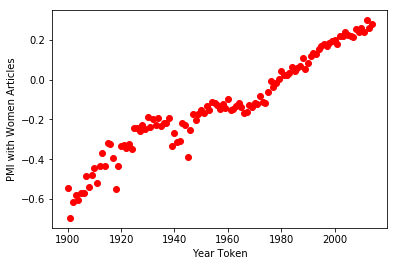

In [178]:
plt.plot(range(1900,2015), [pc.pmi(str(i)) for i in range(1900, 2015)], 'ro')
#plt.axis([0, 6, 0, 20])
plt.xlabel('Year Token')
plt.ylabel('PMI with Women Articles')
#plt.title('Histogram of IQ')
plt.show()

In [182]:
top_words_with_pmi.sort(key = lambda x: x[-1])

In [189]:
top_words_with_pmi[:25]

[('nbay', 26272, -7.611021034611001),
 ('soccerbase', 48215, -6.714110080527057),
 ('touchdowns', 21743, -5.717061075755479),
 ('cfb', 41858, -5.591893589120769),
 ('cfl', 27482, -4.883459824010785),
 ('ahl', 48558, -4.728768699616124),
 ('basho', 27121, -4.485825215739609),
 ('phillies', 18151, -4.408029612896608),
 ('ffffbf', 22239, -4.308870589754527),
 ('touchdown', 20951, -4.146025227102477),
 ('nhl', 152440, -3.980216647530143),
 ('packers', 17685, -3.8653300367238232),
 ('mlb', 112927, -3.765953985535786),
 ('nrl', 17001, -3.7100535643968486),
 ('ffdf9f', 30040, -3.667509684331198),
 ('dfdfdf', 30974, -3.6090002204332388),
 ('redskins', 17049, -3.541022692597691),
 ('sumo', 17618, -3.47376878974522),
 ('nfl', 198100, -3.362192971339228),
 ('braves', 21585, -3.3201713681263234),
 ('ligue', 20050, -3.3153947643584134),
 ('atp', 23513, -3.2587440084557056),
 ('calcio', 36112, -3.251651673848447),
 ('cardinals', 41157, -3.2000989189914497),
 ('hurling', 42983, -3.1796980729197557)]

In [188]:
top_words_with_pmi[-25:]

[('girl', 81774, 1.3043311692138673),
 ('karen', 18868, 1.3107377579413537),
 ('rachel', 19619, 1.320925870895616),
 ('jennifer', 24554, 1.3246692332215506),
 ('amy', 21268, 1.3468364575604284),
 ('laura', 28393, 1.3497051699823768),
 ('kate', 25335, 1.361659806311657),
 ('julie', 19482, 1.3677288569117696),
 ('lisa', 24538, 1.3794512862249828),
 ('gender', 20206, 1.3821934743321176),
 ('woman', 117209, 1.4085554659874795),
 ('gymnastics', 27011, 1.4361599930835922),
 ('girls', 57627, 1.443666437110494),
 ('jessica', 17538, 1.4518054969917902),
 ('michelle', 17688, 1.4548538222469443),
 ('miss', 83631, 1.4843674303589847),
 ('husband', 75006, 1.509566866723068),
 ('ladies', 25061, 1.5567496105259568),
 ('actress', 147860, 1.7006927238502563),
 ('her', 1308263, 1.7244667675788659),
 ('women', 532471, 1.742348800649344),
 ('female', 123970, 1.7434816438590204),
 ('herself', 41532, 1.75370262315033),
 ('she', 1412916, 1.7940272570088585),
 ('actresses', 93472, 1.8524058451615915)]

In [190]:
pc.pmi("wife")

-0.057060278138187925

In [191]:
pc.pmi("husband")

1.509566866723068

In [193]:
pc.pmi("calculus")

-1.3782836948463633

In [215]:
pc.pmi("algebra")

-0.43455580425201745

In [216]:
pc.pmi("geometry")

-0.7521868352706473

In [217]:
pc.pmi("manifold")

-0.9148179789333222

In [218]:
pc.pmi("vector")

-0.8668498910403404

In [208]:
pc.pmi("killed")

-0.438609525439805

In [205]:
pc.pmi("python")

-0.24261275656700754

In [206]:
pc.pmi("java")

-0.3288831679724957

In [210]:
pc.pmi("c")

-1.0698052654783705

In [211]:
pc.pmi("javascript")

-0.5527119286370876

In [213]:
pc.pmi("adascript")

0

In [219]:
[pc.pmi(word) for word in ['racist', 'bigot', 'sexist']]

[0.07980790465355447, -0.4304942959128377, 1.1057827364354074]

# Category Filtering

In [ ]:
fp = FloatProgress(min=0, max=850399)
cc = IntText(value=0, description="Categories")
display(cc, fp)
article_count = 0
category_counts = None

matcher = re.compile("\[\[Category:([^\]]*)", re.IGNORECASE)

category_to_articles = collections.defaultdict(list)

with open("data/gendered-labeled-articles", 'r') as f:
    for line in f:
        article_count += 1
        if article_count % 1000 == 0:
            fp.value = article_count
            cc.value = len(category_to_articles)
        article_id = int(line.split(" ", 1)[0])
        for category in matcher.findall(line):
            category_to_articles[category].append(article_id)

In [ ]:
topic_to_articles = collections.defaultdict(set)
topic_patterns = {
    "programming": re.compile("software|programmer"),
    "sports": re.compile("athlete|sportspeople"),
    "artists": re.compile("artist"),
    "scientist": re.compile("scientist"),
    "fictional": re.compile("fictional"),
    "monarch": re.compile("king|queen|monarch|royal|prince|princess"),
    
    
    #                          "politicians",
     #                         "military personnel",

                              #sportmanager
                              #cleric
       #                       "monarch",
        #                      "Fictional\ characters",
         #                     "nobility",
          #                    "criminals",
           #                   "judges"
    
}


for k,v in category_to_articles.items():
    for topic, pattern in topic_patterns.items():
        if pattern.search(k):
            topic_to_articles[topic].update(v)
            
[(k, len(v)) for (k,v) in topic_to_articles.items()]

In [9]:
fp = FloatProgress(min=0, max=850399)
display(fp)
article_count = 0

topic_writers = {topic: open("data/topic-" + topic + "words", 'w') for topic in topic_to_articles.keys()}

start = time.time()
try:
    with open("data/gendered-labeled-arlticles.stripped", 'r') as f:
        for line in f:
            article_count += 1
            if article_count % 1000 == 0:
                fp.value = article_count
            article_id, words = line.split(" ", 1)
            for topic, ids in topic_to_articles.items():
                if article_id in ids:
                    topic_writers[topic].write(words)
                    topic_writers[topic].write("\n")

finally:        
    for writer in topic_writers.values():
        writer.close()
    print("Articles:", article_count, "Time:", (time.time() - start), "seconds")

FloatProgress(value=0.0, max=850399.0)

Articles: 850399 Time: 7.9872894287109375 seconds


In [21]:
1+1

2

In [7]:
def parse_glove_file(file_path, ndim):
    # File path inside archive
    inner_path = "glove.6B.{:d}d.txt".format(ndim)
    print("Parsing file: {:s}:{:s}".format(file_path, inner_path))
    # Count lines to pre-allocate memory
    line_count = 0
    with open(file_path, 'r') as f:
        for line in f:
            line_count += 1
    print("Found {:,} words.".format(line_count))
    
    # Pre-allocate vectors as a contiguous array
    W = np.zeros((line_count, ndim), dtype=np.float32)
    words = []

    print("Parsing vectors... ", end="")
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            word, numbers = line.split(maxsplit=1)
            words.append(word)
            W[i] = np.fromstring(numbers, dtype=np.float32, sep=" ")
    
    print("Done! (W.shape = {:s})".format(str(W.shape)))
    return words, W

def find_nn_cos(v, Wv, k=10):
    cos_similarity = np.dot(Wv, v) / (np.linalg.norm(v) * np.linalg.norm(Wv, axis=1))
    nns = np.argsort(cos_similarity)[-k:]
    return (nns, cos_similarity[nns])

def analogy(vA, vB, vC, Wv, k=5):
    return find_nn_cos(vB - vA + vC, Wv, k)

class Glove:
    
    def __init__(self, file_path, ndim):
        self.words, self.W = parse_glove_file(file_path, ndim)
        self.word_index = {}
        for i, word in enumerate(self.words):
            self.word_index[word] = i
            
    def vector(self, word):
        return self.W[self.word_index[word]]
    
    def analogy(self, a, b, c, k=5):
        return [self.words[i] for i in analogy(self.vector(a), self.vector(b), self.vector(c), self.W, k)[0]]

In [14]:
glove = {}
topics = ["artists", "monarch", "programming", "scientist", "sports"]
glove = {topic: Glove("data/glove/topic-" + topic + "words-vectors.txt", 200) for topic in topics}

Parsing file: data/glove/topic-artistswords-vectors.txt:glove.6B.200d.txt
Found 172,878 words.
Parsing vectors... Done! (W.shape = (172878, 200))
Parsing file: data/glove/topic-monarchwords-vectors.txt:glove.6B.200d.txt
Found 101,333 words.
Parsing vectors... Done! (W.shape = (101333, 200))
Parsing file: data/glove/topic-programmingwords-vectors.txt:glove.6B.200d.txt
Found 17,607 words.
Parsing vectors... Done! (W.shape = (17607, 200))
Parsing file: data/glove/topic-scientistwords-vectors.txt:glove.6B.200d.txt
Found 81,276 words.
Parsing vectors... Done! (W.shape = (81276, 200))
Parsing file: data/glove/topic-sportswords-vectors.txt:glove.6B.200d.txt
Found 91,223 words.
Parsing vectors... Done! (W.shape = (91223, 200))


In [16]:
glove["all"] = Glove("data/glove/glove.6B.200d.txt", 200)

Parsing file: data/glove/glove.6B.200d.txt:glove.6B.200d.txt
Found 400,001 words.
Parsing vectors... Done! (W.shape = (400001, 200))


In [18]:
glove["artists"].analogy("he", "she", "modern")

['she', 'contemporary', 'her', 'women', 'modern']

In [20]:
glove["artists"].analogy("man", "woman", "paint")

['acrylic', 'oil', 'painting', 'painted', 'paint']

In [88]:
glove["programming"].W.shape

(17607, 200)

In [134]:
def find_nn_cos_with_threshold(a, b, x, Wv, threshold = 0.6):
    ab = a - b
    xys = Wv - x
    cos_similarity = np.dot(xys, ab) / (np.linalg.norm(ab) * np.linalg.norm(xys, axis=1))
    nn = np.nanargmax(cos_similarity)
    return (nn, cos_similarity[nn])

def find_all_pairs_with_threshold(a, b, Wv, threshold):
    matches = []
    for i in range(Wv.shape[0]):
    #for i in range(50):
        if i % 1000 == 0:
            print(i)
        j, d = find_nn_cos_with_threshold(a, b, Wv[i], Wv, threshold)
        if d > threshold:
            matches += [(i, j, d)]
        
    return matches

In [137]:
gsports = glove["sports"]
msports = find_all_pairs_with_threshold(gsports.vector("she"),
                                  gsports.vector("he"),
                                  gsports.W,
                                  0.5)

0


/home/madereth/anaconda3/envs/w266-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000


In [131]:
g = glove["programming"]
m = find_all_pairs_with_threshold(g.vector("she"),
                                  g.vector("he"),
                                  g.W,
                                  0.5)

0


/home/madereth/anaconda3/envs/w266-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600


In [132]:
m

[(17, 235, 1.0000001),
 (27, 262, 0.6511974),
 (69, 235, 0.5440264),
 (194, 235, 0.6359928),
 (11554, 10886, 0.51645917)]

In [133]:
[(g.words[i[0]],g.words[i[1]], i[2]) for i in m]

[('he', 'she', 1.0000001),
 ('his', 'her', 0.6511974),
 ('also', 'she', 0.5440264),
 ('where', 'she', 0.6359928),
 ('usflinfo', 'businessinsiderbio', 0.51645917)]

In [135]:
g = glove["scientist"]
ms = find_all_pairs_with_threshold(g.vector("she"),
                                  g.vector("he"),
                                  g.W,
                                  0.5)

0


/home/madereth/anaconda3/envs/w266-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000


In [136]:
[(g.words[i[0]],g.words[i[1]], i[2]) for i in ms]

[('the', 'she', 0.5233252),
 ('of', 'she', 0.5472787),
 ('in', 'she', 0.5727447),
 ('to', 'her', 0.5099384),
 ('he', 'she', 1.0),
 ('was', 'she', 0.51960063),
 ('for', 'she', 0.54781663),
 ('his', 'her', 0.8312228),
 ('which', 'she', 0.5803153),
 ('also', 'she', 0.6061445),
 ('this', 'her', 0.5041148),
 ('had', 'she', 0.5384969),
 ('one', 'she', 0.5130893),
 ('were', 'her', 0.52489454),
 ('may', 'she', 0.50021696),
 ('years', 'she', 0.52327156),
 ('been', 'she', 0.51635003),
 ('but', 'her', 0.5574061),
 ('published', 'her', 0.5312385),
 ('where', 'she', 0.6118564),
 ('became', 'she', 0.5249684),
 ('during', 'she', 0.53547204),
 ('later', 'she', 0.568919),
 ('him', 'her', 0.5112731),
 ('when', 'she', 0.5515992),
 ('then', 'she', 0.5205146),
 ('many', 'her', 0.5007815),
 ('there', 'she', 0.52698076),
 ('some', 'her', 0.5207492),
 ('worked', 'she', 0.5267218),
 ('made', 'her', 0.5040406),
 ('these', 'her', 0.5011051),
 ('while', 'she', 0.51094985),
 ('since', 'she', 0.53882056),
 ('until'

In [138]:
[(gsports.words[i[0]],gsports.words[i[1]], i[2]) for i in msports]

[('the', 'she', 0.579172),
 ('in', 'she', 0.55628306),
 ('ref', 'she', 0.54113567),
 ('and', 'she', 0.54077613),
 ('of', 'she', 0.53934544),
 ('a', 'she', 0.5583278),
 ('to', 'she', 0.5515262),
 ('http', 'she', 0.5076464),
 ('he', 'she', 1.0),
 ('for', 'she', 0.54486716),
 ('url', 'she', 0.5016218),
 ('cite', 'she', 0.53249764),
 ('was', 'she', 0.66509193),
 ('on', 'she', 0.56037706),
 ('his', 'her', 0.8940843),
 ('accessdate', 'she', 0.5294304),
 ('with', 'she', 0.6024914),
 ('first', 'she', 0.53099513),
 ('season', 'she', 0.5237535),
 ('league', 'she', 0.51617336),
 ('as', 'she', 0.63189346),
 ('men', 'women', 0.52905464),
 ('10', 'she', 0.5487249),
 ('5', 'she', 0.5192066),
 ('by', 'she', 0.52440053),
 ('12', 'she', 0.5518395),
 ('11', 'she', 0.56885874),
 ('club', 'she', 0.5129539),
 ('after', 'she', 0.59224343),
 ('that', 'she', 0.66932565),
 ('august', 'she', 0.5687072),
 ('an', 'she', 0.53950995),
 ('career', 'she', 0.55999166),
 ('work', 'she', 0.5178626),
 ('july', 'she', 0.55

In [26]:
glove["all"].analogy("he", "she", "football")

['hockey', 'volleyball', 'soccer', 'basketball', 'football']

In [30]:
glove["all"].analogy("he", "she", "president")

['presidents', 'presidential', 'clinton', 'vice', 'president']

In [32]:
find_nn_cos(glove["all"].vector("she") - glove["all"].vector("he") + glove["all"].vector("man"), glove["all"].W)

(array([7186,  702, 1606, 2938,   71,   67,  808, 1749,  300,  787]),
 array([0.621892  , 0.63576126, 0.64200103, 0.6599604 , 0.7238898 ,
        0.72987235, 0.737804  , 0.74939495, 0.80364037, 0.86988366],
       dtype=float32))

In [34]:
W = glove["all"].W

In [59]:
m = []

In [58]:
find_nn_cos_with_threshold(glove["all"].vector("she"),
                          glove["all"].vector("he"),
                          glove["all"].vector("man"),
                          glove["all"].W)

/home/madereth/anaconda3/envs/w266-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/madereth/anaconda3/envs/w266-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


(array([[  67],
        [  71],
        [ 787],
        [ 808],
        [1749],
        [2003],
        [2890],
        [2938]]), array([[0.58033943],
        [0.59222955],
        [0.680215  ],
        [0.5694386 ],
        [0.57762533],
        [0.52214944],
        [0.5175899 ],
        [0.53039855]], dtype=float32))

In [42]:
[glove["all"].words[i] for i in [5508, 2890, 2003, 2938,  808, 1749,   67,   71,  787,  300]]

['pregnant',
 'actress',
 'sister',
 'herself',
 'mother',
 'girl',
 'she',
 'her',
 'woman',
 'man']

In [63]:
m += [1]

In [64]:
m


[1, 1]